## **Parameter Definition**

In [1]:
# import libraries
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
intersection_point = (0, 0)  # default value

# @ parameters for blades
# cutting speed of blade
v_cut_2 = 6 # m2/hr
# life time of blade
a_max_cut_blade = 30 # m^2 for 6-8 m2/hr or 15 m^2 for 3-4 m2/hr
span_blade = a_max_cut_blade/v_cut_2  # = 5hr 
# diameter of blade
d_blade = 0.8 # m (600 mm … 1,600 mm)
# thickness of blade
t_blade = 2.2/1000 # m
# weight of blade
w_blade = np.pi * np.square(d_blade/2) * t_blade * 7800 # kg (steel density 7800 kg/m3)

# @ parameters for materials 
# density of materials
rho_light_reinforced_concrete = 2500
rho_hard_reinforced_concrete = 2770
rho_concrete = 2150 # kg/m3 lean concrete
rho_steel = 7850 # kg/m3

# @ CO2 emission of materials

# light_reinforced_concrete_emission = 0.165 # kgCO2eq/kg from KBOB for Switzerland
# hard_reinforced_concrete_emission = 0.358 # kgCO2eq/kg from KBOB for Switzerland
# brick_emission = 0.267 
concrete_emission = 0.0408 # kgCO2eq/kg IPCC2021 EcoInvent 3.10, lean concrete production, with cement CEM II/B | lean concrete | Cutoff, U
civil_concrete_emission = 0.0903 # kgCO2eq/kg IPCC2021 EcoInvent 3.10, concrete production, 37MPa, for civil engineering, with cement, Portland | concrete, 37MPa | Cutoff, U
steel_CO2_emission = 2.3173 # kgCO2eq/kg IPCC2021 EcoInvent 3.10, market for reinforcing steel | reinforcing steel | Cutoff, U

# https://oneclicklca.zendesk.com/hc/en-us/articles/360020943800-Average-Quantities-of-Reinforcement-in-Concrete
light_reinforce_ratio_beam_v = 0.025 # 2.5% of the volume of concrete
# translated to mass ratio
light_reinforce_ratio_beam = light_reinforce_ratio_beam_v*rho_steel/(light_reinforce_ratio_beam_v*rho_steel+(1-light_reinforce_ratio_beam_v)*rho_concrete)
hard_reinforce_ratio_beam_v = 0.045 # 4.5% of the volume of concrete
# translated to mass ratio
hard_reinforce_ratio_beam = hard_reinforce_ratio_beam_v*rho_steel/(hard_reinforce_ratio_beam_v*rho_steel+(1-hard_reinforce_ratio_beam_v)*rho_concrete)
light_reinforce_ratio_slab_v = 0.009 # 0.9% of the volume of concrete
# translated to mass ratio
light_reinforce_ratio_slab = light_reinforce_ratio_slab_v*rho_steel/(light_reinforce_ratio_slab_v*rho_steel+(1-light_reinforce_ratio_slab_v)*rho_concrete)
hard_reinforce_ratio_slab_v = 0.017 # 1.7% of the volume of concrete
# translated to mass ratio
hard_reinforce_ratio_slab = hard_reinforce_ratio_slab_v*rho_steel/(hard_reinforce_ratio_slab_v*rho_steel+(1-hard_reinforce_ratio_slab_v)*rho_concrete)

rho_light_reinforced_concrete_beam = (1-light_reinforce_ratio_beam)*rho_concrete + light_reinforce_ratio_beam*rho_steel # kg/m3, low strength concrete
rho_hard_reinforced_concrete_beam = (1-hard_reinforce_ratio_beam)*rho_concrete + hard_reinforce_ratio_beam*rho_steel # kg/m3, high strength concrete
rho_light_reinforced_concrete_slab = (1-light_reinforce_ratio_slab)*rho_concrete + light_reinforce_ratio_slab*rho_steel # kg/m3, low strength concrete
rho_hard_reinforced_concrete_slab = (1-hard_reinforce_ratio_slab)*rho_concrete + hard_reinforce_ratio_slab*rho_steel # kg/m3, high strength concrete

light_reinforced_concrete_emission_beam = (1-light_reinforce_ratio_beam)*concrete_emission + light_reinforce_ratio_beam*steel_CO2_emission  # kgCO2eq/kg, low strength concrete
hard_reinforced_concrete_emission_beam = (1-hard_reinforce_ratio_beam)*civil_concrete_emission + hard_reinforce_ratio_beam*steel_CO2_emission # kgCO2eq/kg, high strength concrete
light_reinforced_concrete_emission_slab = (1-light_reinforce_ratio_slab)*concrete_emission + light_reinforce_ratio_slab*steel_CO2_emission  # kgCO2eq/kg, low strength concrete
hard_reinforced_concrete_emission_slab = (1-hard_reinforce_ratio_slab)*civil_concrete_emission + hard_reinforce_ratio_slab*steel_CO2_emission # kgCO2eq/kg, high strength concrete


green_electricity_CO2_emission = 0.0023 # kgCO2eq/kWh IPCC2021 EcoInvent 3.10, market for electricity, medium voltage | electricity, medium voltage | Cutoff, U CH
gray_electricity_CO2_emission = 0.9230 # kgCO2eq/kWh IPCC2021 EcoInvent 3.10, market for electricity, medium voltage | electricity, medium voltage | Cutoff, U CN
generator_CO2_emission = 76.4400 # kgCO2eq/hour IPCC2021 EcoInvent 3.10, machine operation, diesel, >= 74.57 kW, generators | machine operation, diesel, >= 74.57 kW, generators | Cutoff, U

diamond_blade_CO2_emission = (334.123*80/35)/span_blade # kgCO2/h # reference: https://ieeexplore.ieee.org/document/10021341

# @ wall saw parameters
# power = 20 # kW, Hilti wall saw DST 20-CA 
power = 32 # kW, Hilti wall saw DST 20-CA (or 40kVA generator using diesel fuel which is around 32kW)
span_machine = 1000 # hr
w_machine = 32 # kg

# @ parameters for cutting
fast_cut_speed_area = 6 # m2/hour
slow_cut_speed_area = 3 # m2/hour
cutting_speed = 2-(2-0.7)/(15-5)*(12-5) # 1.08m/min @ 12cm depth

# @ dimensional parameters for a concrete beam/wall
cutting_width = beam_width = 0.4 # meters
cutting_depth = beam_depth = 0.4

# @ transportation parameters
distance_factory_b = 100 # km
# the reuse distance is a times the distance from factory to site
a = 1 
distance_a_storage_b_total = a * distance_factory_b # km
# carbon emission of different transportation methods
# lorry_CO2_emission = 0.144 # kgCO2eq/tonkm
# truck_CO2_emission = 0.183 # kgCO2eq/tonkm, 16-32 ton truck, assuming 8m|3 of concrete of 32 ton
lorry_CO2_emission = truck_CO2_emission = 0.15221 ## kgCO2eq/tonkm EURO6, IPCC2021 EcoInvent 3.10, , transport, freight, lorry, all sizes, EURO3 to generic market for transport, freight, lorry, unspecified | transport, freight, lorry, unspecified | Cutoff, U
# 0.1577 # kgCO2eq/tonkm EURO3, IPCC2021 EcoInvent 3.10, , transport, freight, lorry, all sizes, EURO3 to generic market for transport, freight, lorry, unspecified | transport, freight, lorry, unspecified | Cutoff, U
# load capacity of lorry or concrete truck
size_truck = 9 # m3
weight_concrete_truck = size_truck * rho_concrete # 19.35 ton
lorry_load_capacity = 12e3 # ton
lorry_space_capacity = 9
# Additional information:
# max cutting depth 73 cm
# guide cut at half power consumption at 4cm depth

# assume cutting concrete has 2% loss
glue_roundup_ratio =0.02

## **Function Definition**

In [2]:
# calculate the maximum number of concrete beam to be transported for reuse
def max_concrete_beam(cutting_length,cutting_depth, cutting_width,rho):
    v_concrete_beam = cutting_length * cutting_depth*cutting_width
    weight_concrete_beam = v_concrete_beam * rho
    max_num_concrete_beam = np.minimum(np.floor(lorry_space_capacity / v_concrete_beam),np.floor(lorry_load_capacity / weight_concrete_beam))
    return max_num_concrete_beam

# calculate the maximum number of concrete beam to be transported for reuse
def max_concrete_wall(cut_width,cut_height,wall_thickness,rho):
    v_concrete_wall = cut_width * cut_height * wall_thickness
    weight_concrete_wall = v_concrete_wall * rho
    max_num_concrete_wall = np.minimum(np.floor(lorry_space_capacity / v_concrete_wall),np.floor(lorry_load_capacity / weight_concrete_wall))
    return max_num_concrete_wall

# calculate the total weight of concrete beam to be transported for reuse
def total_weight_concrete_beam(cutting_length,cutting_depth, cutting_width, rho):
    v_concrete_beam = cutting_length *cutting_depth* cutting_width
    weight_concrete_beam = v_concrete_beam * rho
    max_num_concrete_beam = np.minimum(np.floor(lorry_space_capacity / v_concrete_beam),np.floor(lorry_load_capacity / weight_concrete_beam)) #7
    total_weight_concrete_beam = max_num_concrete_beam * weight_concrete_beam
    return total_weight_concrete_beam

# calculate the carbon emission for manufacturing the concrete beam
def manufacturing_cost_beam(carbon_emission, cutting_length, cutting_depth, cutting_width, rho):
    beam_volumne = cutting_length * cutting_depth* cutting_width
    manufacturing_CO2_cost = carbon_emission * beam_volumne * rho
    return manufacturing_CO2_cost

# calculate the carbon emission for manufacturing the concrete wall
def manufacturing_cost_wall(carbon_emission, wall_thickness, wall_width, wall_height, rho):
    wall_volume = wall_thickness * wall_width * wall_height
    manufacturing_CO2_cost = carbon_emission * wall_volume * rho
    return manufacturing_CO2_cost

# calculate the carbon emission for cutting the concrete beam, generator
def cut_impact(cutting_time):
    # impact_energy = (power * cutting_time) * (electricity_CO2_emission) # impact of electricity consumption 
    impact_energy = (cutting_time) * (generator_CO2_emission) # impact of generator consumption 
    impact_blade = diamond_blade_CO2_emission * cutting_time
    impact_machine = cutting_time / span_machine * steel_CO2_emission * w_machine
    cut_impact = impact_energy + impact_blade + impact_machine
    return cut_impact

def reuse_glue_cost(weight,glue_roundup_ratio, carbon_emission):
    glue_cost = weight * glue_roundup_ratio * carbon_emission
    return glue_cost

# calculate the carbon emission for cutting the concrete beam
def cut_impact_electricity(electricity_CO2_emission, cutting_time):
    impact_energy = (power * cutting_time) * (electricity_CO2_emission) # impact of electricity consumption 
    # impact_energy = (cutting_time) * (generator_CO2_emission) # impact of generator consumption 
    impact_blade = diamond_blade_CO2_emission * cutting_time
    impact_machine = cutting_time / span_machine * steel_CO2_emission * w_machine
    cut_impact = impact_energy + impact_blade + impact_machine
    return cut_impact

# calculate the cutting time for the concrete beam
def cutting_time_beam(cutting_depth,cutting_width,cut_speed_area):
    cutting_pass = np.ceil(cutting_depth/0.12) * 2 # back and forth cut @12cm depth
    cutting_time_speed = 2 * (cutting_width /cutting_speed * cutting_pass + cutting_width/(cutting_speed/2))/60 # hours # two cuts
    cutting_time_area = 2 * ( cutting_width * cutting_depth/ cut_speed_area + cutting_width/(cutting_speed/2)/60)
    return max(cutting_time_speed, cutting_time_area)
    # return cutting_time_area

# calculate the cutting time for the concrete wall
def cutting_time_wall(wall_width, wall_height, wall_thickness, cut_speed_area):
    cutting_length = 2*(wall_width+wall_height)
    cutting_depth = wall_thickness
    # number of passes
    cutting_pass = np.ceil(cutting_depth/0.12) * 2 # back and forth cut @12cm depth
    # cutting time depending on speed or area
    cutting_time_speed = (cutting_length /cutting_speed * cutting_pass + cutting_length/(cutting_speed/2))/60 # hours 
    cutting_time_area = ( cutting_length/2 * cutting_depth/ cut_speed_area  + cutting_length/(cutting_speed/2)/60)  
    return max(cutting_time_speed, cutting_time_area)
    # return cutting_time_area

# calculate the carbon emission for transportation of reused concrete beam
def transport_impact_lorry(total_weight_concrete_beam,distance): # assume fully loaded lorry
    transport_impact_lorry = distance * total_weight_concrete_beam/1000 * lorry_CO2_emission
    return transport_impact_lorry

# calculate the carbon emission for transportation of new concrete
def transport_impact_truck(distance,weight_concrete_truck):
    transport_impact_truck = distance * weight_concrete_truck/1000 * truck_CO2_emission 
    # transport_impact_truck = concrete_truck_transport * truck_CO2_emission
    return transport_impact_truck

## **Visualizations**

### **Wall, Maximal loaded, Assuming Transportation Distances are Constant**

In [9]:
# @ fixed wall height
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve

# Define the range of size
wall_width_range = np.linspace(0.001, 4, 100)  # Example range for cutting length
wall_height =3  # Example range for cutting length
wall_thickness = 0.2

# Initialize arrays to store the reuse impact and new impact values
reuse_impact_values = []
new_impact_values = []
difference_values = []

# Set constant transportation distances
transportation_distance = 100  # km, assumed constant distance from factory to site
a = 1

for wall_width in wall_width_range:
    # Calculate cutting time and other necessary parameters
    # wall_width = v_concrete_wall / (wall_thickness * wall_height)
    v_concrete_wall = wall_width * (wall_thickness * wall_height)

    cutting_time = cutting_time_wall(wall_width, wall_height, wall_thickness, fast_cut_speed_area)
    max_num_concrete_wall = max_concrete_wall(wall_width, wall_height, wall_thickness, rho_light_reinforced_concrete_slab)
    total_weight_wall = v_concrete_wall * rho_light_reinforced_concrete_slab * max_num_concrete_wall
    
    # Calculate reuse impact and new impact
    reuse_impact = cut_impact(cutting_time)*max_num_concrete_wall + transport_impact_lorry(total_weight_wall, a * transportation_distance) \
                + reuse_glue_cost(total_weight_wall, glue_roundup_ratio, light_reinforced_concrete_emission_slab)
    new_impact = manufacturing_cost_wall(light_reinforced_concrete_emission_slab, wall_thickness, wall_width, wall_height, rho_light_reinforced_concrete_slab) *max_num_concrete_wall\
                + transport_impact_truck(transportation_distance, total_weight_wall)

    # Store the impact values
    # reuse_impact_values.append(reuse_impact)
    # new_impact_values.append(new_impact)
    difference_values.append(reuse_impact - new_impact)


# Create a line plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=wall_width_range, y=difference_values, name='Impact Difference'))

# add intersection point
tolerance = 1e-5
intersection_func = lambda x: np.interp(x, wall_width_range, difference_values)
intersection, = fsolve(intersection_func, wall_width_range[0], xtol=tolerance)
fig.add_trace(go.Scatter(x=[intersection], y=[np.interp(intersection, wall_width_range, difference_values)],
                         mode='markers', name='Intersection Point'))
# Print the intersection point
print("Intersection Point: Cutting Length =", intersection)

# Set plot layout
fig.update_layout(
    xaxis_title='Concrete Wall Width in m',
    yaxis_title='Impact in kg CO2eq',
    title='Environmental Impact vs. Concrete Volume',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)

# Update layout to hide default x-axis line and emphasize y=0 line
fig.update_layout(
    xaxis=dict(
        showline=False,  # Hide the default x-axis line
        showticklabels=True,  # Show tick labels on the x-axis
        ticks='',  # Hide ticks along the x-axis
        zeroline=True,  # Ensure the zero line is shown
        zerolinewidth=2,  # Adjust the width of the zero line if you want it more visible
        zerolinecolor='black'  # Set the color of the zero line
    ),
    yaxis=dict(
        zeroline=True,  # Show the zero line for y-axis
        zerolinewidth=2,  # Adjust the width of the zero line
        zerolinecolor='black'  # Set the color of the zero line
    )
)
fig.update_xaxes(range=[0, 4])  # Set x-axis limits
fig.update_yaxes(range=[-1000, 3000])  # Set y-axis limits

fig.update_layout(template="simple_white")
# Show the plot
fig.show()


Intersection Point: Cutting Length = 1.057060960824068


In [50]:
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve

# Define the range of size
wall_width_range = np.linspace(0.001, 4, 100)  # Example range for wall width
wall_height_range = np.linspace(0.001, 4, 100)  # Example range for wall height
wall_thickness = 0.2

# Initialize arrays to store the reuse impact and new impact values
difference_values = np.zeros((len(wall_width_range), len(wall_height_range)))

# Set constant transportation distances
transportation_distance = 100  # km, assumed constant distance from factory to site
a = 1

for i, wall_width in enumerate(wall_width_range):
    for j, wall_height in enumerate(wall_height_range):
        # Calculate volume of concrete wall
        v_concrete_wall = wall_width * wall_height * wall_thickness

        cutting_time = cutting_time_wall(wall_width, wall_height, wall_thickness, fast_cut_speed_area)
        max_num_concrete_wall = max_concrete_wall(wall_width, wall_height, wall_thickness, rho_light_reinforced_concrete_slab)
        total_weight_wall = v_concrete_wall * rho_light_reinforced_concrete_slab * max_num_concrete_wall
        
        # Calculate reuse impact and new impact
        reuse_impact = cut_impact(cutting_time)* max_num_concrete_wall + transport_impact_lorry(total_weight_wall, a * transportation_distance)\
                     +  reuse_glue_cost(total_weight_wall, glue_roundup_ratio, light_reinforced_concrete_emission_slab)
        new_impact = manufacturing_cost_wall(light_reinforced_concrete_emission_slab, wall_thickness, wall_width, wall_height, rho_light_reinforced_concrete_slab) * max_num_concrete_wall\
                    + transport_impact_truck(transportation_distance, total_weight_wall)

        # Store the impact values
        difference_values[i, j] = reuse_impact - new_impact

# At this point, difference_values is a 2D array containing the impact differences for each combination of wall_width and wall_height.
# To visualize this, you may need to adjust the plotting logic to accommodate the 2D nature of your results, such as using a 3D surface plot.

# Example of creating a 3D plot with Plotly
fig = go.Figure(data=[go.Surface(z=difference_values, x=wall_width_range, y=wall_height_range, colorscale='Viridis', cmin=-1000, cmax=3000)])

fig.update_layout(title='Environmental Impact Difference Across Wall Dimensions', autosize=False, width=800, height=600,
                  margin=dict(l=65, r=50, b=65, t=90), scene=dict(xaxis_title='Wall Width (m)', yaxis_title='Wall Height (m)', zaxis_title='Impact Difference (kg CO2eq)'), template="simple_white")

# update color scale limits
fig.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor="limegreen", project_z=True))

# set axis range
fig.update_layout(scene=dict(xaxis=dict(range=[0, 4]), yaxis=dict(range=[0, 4]), zaxis=dict(range=[-1000, 3000])))
fig.show()


In [51]:
import numpy as np
import plotly.graph_objects as go

# Assuming the existence of functions and variables for calculation

# Define the range of size
wall_width_range = np.linspace(0.001, 8, 100)  # Example range for wall width
wall_height_range = np.linspace(0.001, 8, 100)  # Example range for wall height
wall_thickness = 0.2

# Initialize a 2D array for difference values
difference_values = np.zeros((len(wall_width_range), len(wall_height_range)))

# Set constant transportation distances
transportation_distance = 100  # km, assumed constant distance from factory to site
a = 1

for i, wall_width in enumerate(wall_width_range):
    for j, wall_height in enumerate(wall_height_range):
        # Calculate volume of concrete wall
        v_concrete_wall = wall_width * wall_height * wall_thickness

        cutting_time = cutting_time_wall(wall_width, wall_height, wall_thickness, fast_cut_speed_area)
        max_num_concrete_wall = max_concrete_wall(wall_width, wall_height, wall_thickness, rho_light_reinforced_concrete_slab)
        total_weight_wall = v_concrete_wall * rho_light_reinforced_concrete_slab * max_num_concrete_wall
        
        # Calculate reuse impact and new impact
        reuse_impact = cut_impact(cutting_time)* max_num_concrete_wall + transport_impact_lorry(total_weight_wall, a * transportation_distance)\
                     +  reuse_glue_cost(total_weight_wall, glue_roundup_ratio, light_reinforced_concrete_emission_slab)
        new_impact = manufacturing_cost_wall(light_reinforced_concrete_emission_slab, wall_thickness, wall_width, wall_height, rho_light_reinforced_concrete_slab) * max_num_concrete_wall\
                    + transport_impact_truck(transportation_distance, total_weight_wall)

        # Store the impact values
        difference_values[i, j] = reuse_impact - new_impact


# Convert calculations to code as necessary using provided functions and variables

# Create a 2D heatmap using Plotly
fig = go.Figure(data=go.Heatmap(
    z=difference_values,
    x=wall_width_range,
    y=wall_height_range,
    colorscale='Viridis',
    colorbar=dict(title='Impact Difference (kg CO2eq)'),
    zmin=-1000,  # Set minimum value of the color scale
    zmax=2000,   # Set maximum value of the color scale
))


# Add a contour plot with a single level at 0 to indicate where impact equals zero
fig.add_trace(go.Contour(
    z=difference_values,
    x=wall_width_range,
    y=wall_height_range,
    contours=dict(
        start=0,
        end=0,
        size=0,
    ),
    line=dict(width=2, color='red'),  # Customize line appearance
    showscale=False,  # Hide contour scale since only one level is used

    colorscale=[[0, 'rgba(0,0,0,0)'], [1, 'rgba(0,0,0,0)']],  # Set transparent colorscale
    
    name='Impact = 0',
))

fig.update_layout(
    title='Environmental Impact Difference Across Wall Dimensions',
    xaxis_title='Wall Width (m)',
    yaxis_title='Wall Height (m)',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90),
    template="simple_white"
)

# Show the plot
fig.show()


In [10]:
wall_width = 1
wall_height = 1
wall_thickness = 0.2
a = 1
transportation_distance = 100  # km, assumed constant distance from factory to site
v_concrete_wall = wall_width * wall_height * wall_thickness

cutting_time = cutting_time_wall(wall_width, wall_height, wall_thickness, fast_cut_speed_area)
max_num_concrete_wall = max_concrete_wall(wall_width, wall_height, wall_thickness, rho_light_reinforced_concrete_slab)
total_weight_wall = v_concrete_wall * rho_light_reinforced_concrete_slab * max_num_concrete_wall

# Calculate reuse impact and new impact
reuse_impact = cut_impact(cutting_time)* max_num_concrete_wall + transport_impact_lorry(total_weight_wall, a * transportation_distance)\
                +  reuse_glue_cost(total_weight_wall, glue_roundup_ratio, light_reinforced_concrete_emission_slab)
new_impact = manufacturing_cost_wall(light_reinforced_concrete_emission_slab, wall_thickness, wall_width, wall_height, rho_light_reinforced_concrete_slab) * max_num_concrete_wall\
            + transport_impact_truck(transportation_distance, total_weight_wall)
print(reuse_impact, new_impact)

2307.3789818709984 1505.7319510818313


In [53]:
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve

# Assuming the existence of functions and variables for calculation

# Define the range of size
wall_width_range = np.linspace(0.001, 4, 200)  # Example range for wall width
wall_height_range = np.linspace(0.001, 4, 200)  # Example range for wall height
wall_thickness = 0.2

# Initialize a list to store cutting area and corresponding average impact difference
cutting_areas = []
average_difference_values = []

# Set constant transportation distances
transportation_distance = 100  # km, assumed constant distance from factory to site
a = 1

for wall_width in wall_width_range:
    for wall_height in wall_height_range:
        # Calculate cutting area
        cutting_area = 2* (wall_width + wall_height) * wall_thickness

        v_concrete_wall = wall_width * wall_height * wall_thickness
        cutting_time = cutting_time_wall(wall_width, wall_height, wall_thickness, fast_cut_speed_area)
        max_num_concrete_wall = max_concrete_wall(wall_width, wall_height, wall_thickness, rho_light_reinforced_concrete_slab)
        total_weight_wall = v_concrete_wall * rho_light_reinforced_concrete_slab * max_num_concrete_wall
        
        # Calculate reuse impact and new impact
        reuse_impact = cut_impact(cutting_time)* max_num_concrete_wall + transport_impact_lorry(total_weight_wall, a * transportation_distance)\
             +  reuse_glue_cost(total_weight_wall, glue_roundup_ratio, light_reinforced_concrete_emission_slab)
        new_impact = manufacturing_cost_wall(light_reinforced_concrete_emission_slab, wall_thickness, wall_width, wall_height, rho_light_reinforced_concrete_slab) * max_num_concrete_wall\
                    + transport_impact_truck(transportation_distance, total_weight_wall)

        # Since cutting area varies with each width-height combination, store each unique area and its corresponding impact difference
        cutting_areas.append(cutting_area)
        average_difference_values.append(reuse_impact - new_impact)

# Since multiple width-height combinations can result in the same cutting area, aggregate the impact differences by cutting area
unique_cutting_areas = list(set(cutting_areas))  # Get unique cutting areas
aggregate_impacts = [np.mean([average_difference_values[i] for i, area in enumerate(cutting_areas) if area == unique_area]) for unique_area in unique_cutting_areas]

# # First, sort the unique cutting areas and corresponding aggregate impacts
# sorted_indices = np.argsort(unique_cutting_areas)
# sorted_cutting_areas = np.array(unique_cutting_areas)[sorted_indices]
# sorted_aggregate_impacts = np.array(aggregate_impacts)[sorted_indices]


# Plotting
fig = go.Figure()
fig.add_trace(go.Scatter(x=unique_cutting_areas, y=aggregate_impacts, mode='markers', name='Impact Difference'))

# Set plot layout
fig.update_layout(
    xaxis_title='Cutting Area (m^2)',
    yaxis_title='Average Impact Difference (kg CO2eq)',
    title='Average Environmental Impact Difference vs. Cutting Area',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90),
    template="simple_white"
)

# Update layout to hide default x-axis line and emphasize y=0 line
fig.update_layout(
    xaxis=dict(
        showline=False,  # Hide the default x-axis line
        showticklabels=True,  # Show tick labels on the x-axis
        ticks='',  # Hide ticks along the x-axis
        zeroline=True,  # Ensure the zero line is shown
        zerolinewidth=2,  # Adjust the width of the zero line if you want it more visible
        zerolinecolor='black'  # Set the color of the zero line
    ),
    yaxis=dict(
        zeroline=True,  # Show the zero line for y-axis
        zerolinewidth=2,  # Adjust the width of the zero line
        zerolinecolor='black'  # Set the color of the zero line
    )
)
fig.update_xaxes(range=[0, 3.2])  # Set x-axis limits
fig.update_yaxes(range=[-1000, 5000])  # Set y-axis limits

fig.update_layout(template="simple_white")
# Show the plot
fig.show()


### **Beam, Maximal loaded, Assuming Transportation Distances are Constant**

In [4]:
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve

# Define the range of cutting length
cutting_length_range = np.linspace(0.01, 8, 100)  # Example range for cutting length

# Initialize arrays to store the reuse impact and new impact values
difference_values = []

# Set constant transportation distances
transportation_distance = 100  # km, assumed constant distance from factory to site
a = 1
# Calculate reuse impact and new impact for each cutting length
for cutting_length in cutting_length_range:
    # Calculate cutting time and other necessary parameters
    cutting_time = cutting_time_beam(cutting_depth, cutting_width, slow_cut_speed_area)
    max_num_concrete_beam = max_concrete_beam(cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam)
    total_weight_beam = total_weight_concrete_beam(cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam)
    
    # Calculate reuse impact and new impact
    reuse_impact =  transport_impact_lorry(total_weight_beam, a * transportation_distance)\
                    + cut_impact(cutting_time) * max_num_concrete_beam\
                    + reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam)         
    new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length,cutting_depth, cutting_width, rho_light_reinforced_concrete_beam) * max_num_concrete_beam\
                + transport_impact_truck(transportation_distance, total_weight_beam)
    difference = reuse_impact - new_impact
    
    # Store the impact values
    difference_values.append(difference)
    
# Find the intersection point with tolerance
tolerance = 1e-5
intersection_func = lambda x: np.interp(x, cutting_length_range, difference_values)
intersection, = fsolve(intersection_func, cutting_length_range[0], xtol=tolerance)

# Print the intersection point
print("Intersection Point: Cutting Length =", intersection)

# Create a line plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=cutting_length_range, y=difference_values, name='Impact Difference'))    
# fig.add_trace(go.Scatter(x=cutting_length_range, y=new_impact_values, name='New Impact'))

# Add marker for the intersection point
fig.add_trace(go.Scatter(x=[intersection], y=[np.interp(intersection, cutting_length_range, difference_values)],
                         mode='markers', name='Intersection Point'))

# Set plot layout
fig.update_layout(
    xaxis_title='Cutting Length in m',
    yaxis_title='Impact in kg CO2eq',
    title='Environmental Impact vs. Cutting Length',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90),
    # yaxis=dict(zeroline=True, zerolinewidth=2, zerolinecolor='black'),  # Emphasize y = 0 line
)

# Update layout to hide default x-axis line and emphasize y=0 line
fig.update_layout(
    xaxis=dict(
        showline=False,  # Hide the default x-axis line
        showticklabels=True,  # Show tick labels on the x-axis
        ticks='outside',  # Show ticks along the x-axis
        dtick=0.5,  # Set the tick interval
        zeroline=True,  # Ensure the zero line is shown
        zerolinewidth=2,  # Adjust the width of the zero line if you want it more visible
        zerolinecolor='black'  # Set the color of the zero line
    ),
    yaxis=dict(
        showline=True,  # Show the y-axis line
        showticklabels=True,  # Show tick labels on the y-axis
        ticks='outside',  # Show ticks along the y-axis
        zeroline=True,  # Show the zero line for y-axis
        zerolinewidth=2,  # Adjust the width of the zero line
        zerolinecolor='black'  # Set the color of the zero line
    )
)
fig.update_xaxes(range=[0, 8])  # Set x-axis limits
fig.update_yaxes(range=[-3500, 3000])  # Set y-axis limits
fig.update_layout(template="simple_white")
# Show the plot
fig.show()
# print impact difference at specific cutting length
cutting_length = 1
cutting_time = cutting_time_beam(cutting_depth, cutting_width, slow_cut_speed_area)
max_num_concrete_beam = max_concrete_beam(cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam)
total_weight_beam = total_weight_concrete_beam(cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam)


Intersection Point: Cutting Length = 0.31281570471715214


C:\Users\xiongs\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.



In [5]:
# Placeholder constants for low and high cutting speeds
low_cutting_speed = 0.5  # Arbitrary low cutting speed
high_cutting_speed = 6.0  # Arbitrary high cutting speed
transportation_distance = 100  # km, assumed constant distance from factory to site
a = 1

# Recalculate the impact differences for low and high cutting speeds
difference_values_low_speed = []
difference_values_high_speed = []

for cutting_length in cutting_length_range:
    max_num_concrete_beam = max_concrete_beam(cutting_length,cutting_depth, cutting_width, rho_light_reinforced_concrete_beam)
    total_weight_beam = total_weight_concrete_beam(cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam)
    
    # Low cutting speed impact calculation
    cutting_time_low = cutting_time_beam(cutting_depth,cutting_width,low_cutting_speed)
    reuse_impact_low_speed = cut_impact(cutting_time_low) * max_num_concrete_beam \
                + transport_impact_lorry(total_weight_beam, a * transportation_distance) + reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam)   
    new_impact_low_speed = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam) * max_num_concrete_beam\
                + transport_impact_truck(transportation_distance, total_weight_beam)
    difference_low_speed = reuse_impact_low_speed - new_impact_low_speed
    
    # High cutting speed impact calculation
    cutting_time_high = cutting_time_beam(cutting_depth,cutting_width,high_cutting_speed)
    reuse_impact_high_speed = cut_impact(cutting_time_high) * max_num_concrete_beam \
                + transport_impact_lorry(total_weight_beam, a * transportation_distance) + reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam)   
    new_impact_high_speed = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam) * max_num_concrete_beam\
                + transport_impact_truck(transportation_distance, total_weight_beam)
    difference_high_speed = reuse_impact_high_speed - new_impact_high_speed
    
    # Store the calculated differences
    difference_values_low_speed.append(difference_low_speed)
    difference_values_high_speed.append(difference_high_speed)

# Update the plot with shaded areas for cutting speed impact range
fig.add_trace(go.Scatter(x=cutting_length_range, y=difference_values_low_speed,
                         fill=None, mode='lines', line=dict(color="blue"), showlegend=True, name='Low Cutting Speed Impact'))
fig.add_trace(go.Scatter(x=cutting_length_range, y=difference_values_high_speed,
                         fill='tonexty', mode='lines', line=dict(color="blue"), showlegend=True, name='High Cutting Speed Impact'))

# Make sure you include the original plot lines and intersection point as before

# Show the updated plot (use fig.show() in a Jupyter Notebook or equivalent environment)


In [6]:
# Recalculate the impact differences for low and high transportation scenarios
difference_values_low_transport = []
difference_values_high_transport = []
low_transportation_distance = 50
high_transportation_distance = 300
low_a_ratio = 0.5
high_a_ratio = 2.5
for cutting_length in cutting_length_range:
    cutting_time = cutting_time_beam(cutting_depth,cutting_width,slow_cut_speed_area)
    max_num_concrete_beam = max_concrete_beam(cutting_length,cutting_depth, cutting_width,  rho_light_reinforced_concrete_beam)
    total_weight_beam = total_weight_concrete_beam(cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam)
    
    # Low transportation distance impact calculation
    reuse_impact_low = cut_impact(cutting_time) * max_num_concrete_beam \
                + transport_impact_lorry(total_weight_beam, low_a_ratio * low_transportation_distance) + reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam)   
    new_impact_low = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam) * max_num_concrete_beam\
                + transport_impact_truck(low_transportation_distance, total_weight_beam)
    difference_low = reuse_impact_low - new_impact_low
    
    # High transportation distance impact calculation
    reuse_impact_high = cut_impact(cutting_time) * max_num_concrete_beam \
                + transport_impact_lorry(total_weight_beam, high_a_ratio * high_transportation_distance) + reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam)   
    new_impact_high = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam) * max_num_concrete_beam\
                + transport_impact_truck(high_transportation_distance, total_weight_beam)
    difference_high = reuse_impact_high - new_impact_high
    
    # Store the calculated differences
    difference_values_low_transport.append(difference_low)
    difference_values_high_transport.append(difference_high)

# Update the plot with shaded areas for transportation impact range
fig.add_trace(go.Scatter(x=cutting_length_range, y=difference_values_low_transport,
                         fill=None, mode='lines', line=dict(color="darkorange"), showlegend=True, name='Low Transport Impact'))
fig.add_trace(go.Scatter(x=cutting_length_range, y=difference_values_high_transport,
                         fill='tonexty', mode='lines', line=dict(color="darkorange"), showlegend=True, name='High Transport Impact'))

# Make sure you include the original plot lines and intersection point as before

# Show the updated plot (use fig.show() in a Jupyter Notebook or equivalent environment)


In [7]:
# Placeholder constants for low and high electricity CO2 emissions
low_electricity_CO2_emission = 0.0023 # Arbitrary low CO2 emission per unit of electricity (kg CO2eq per kWh)
# medium_electricity_CO2_emission = 0.923 # Arbitrary medium CO2 emission per unit of electricity (kg CO2eq per kWh)
# high_electricity_CO2_emission = 1.6  # Arbitrary high CO2 emission per unit of electricity (kg CO2eq per kWh)
high_electricity_CO2_emission = 0.923  # Arbitrary high CO2 emission per unit of electricity (kg CO2eq per kWh)

transportation_distance = 100  # km, assumed constant distance from factory to site
a = 1
def cut_impact_electricity(electricity_CO2_emission, cutting_time):
    impact_energy = (power * cutting_time) * (electricity_CO2_emission) # impact of electricity consumption 
    impact_blade = diamond_blade_CO2_emission * cutting_time
    impact_machine = cutting_time / span_machine * steel_CO2_emission * w_machine
    cut_impact = impact_energy + impact_blade + impact_machine
    return cut_impact

# Recalculate the impact differences for low and high electricity CO2 emissions
difference_values_low_emission = []
difference_values_medium_emission = []
difference_values_high_emission = []

for cutting_length in cutting_length_range:
    cutting_time = cutting_time_beam(cutting_depth,cutting_width,fast_cut_speed_area)  # Assuming cutting_time_beam is defined elsewhere without speed variation for simplicity
    max_num_concrete_beam = max_concrete_beam(cutting_length,cutting_depth, cutting_width,  rho_light_reinforced_concrete_beam)
    total_weight_beam = total_weight_concrete_beam(cutting_length,cutting_depth, cutting_width,  rho_light_reinforced_concrete_beam)
    
    # Low electricity CO2 emission impact calculation
    reuse_impact_low_emission = cut_impact_electricity(low_electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
                + transport_impact_lorry(total_weight_beam, a * transportation_distance) + reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam)   
    new_impact_low_emission = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam) * max_num_concrete_beam\
                + transport_impact_truck(transportation_distance, total_weight_beam)
    difference_low_emission = reuse_impact_low_emission - new_impact_low_emission
    
    # # Medium electricity CO2 emission impact calculation
    # reuse_impact_medium_emission = cut_impact_electricity(medium_electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
    #             + transport_impact_lorry(total_weight_beam, a * transportation_distance) + reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam)   
    # new_impact_medium_emission = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam) * max_num_concrete_beam\
    #             + transport_impact_truck(transportation_distance, total_weight_beam)
    # difference_medium_emission = reuse_impact_medium_emission - new_impact_medium_emission


    # High electricity CO2 emission impact calculation
    reuse_impact_high_emission = cut_impact_electricity(high_electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
                + transport_impact_lorry(total_weight_beam, a * transportation_distance) + reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam)   
    new_impact_high_emission = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam) * max_num_concrete_beam\
                + transport_impact_truck(transportation_distance, total_weight_beam)
    difference_high_emission = reuse_impact_high_emission - new_impact_high_emission
    
    # Store the calculated differences
    difference_values_low_emission.append(difference_low_emission)
    difference_values_high_emission.append(difference_high_emission)
    # difference_values_medium_emission.append(difference_medium_emission)


# Add the medium emission impact line to the plot
# fig.add_trace(go.Scatter(x=cutting_length_range, y=difference_values_medium_emission,
#                          mode='lines', line=dict(color="blue"), showlegend=True, name='Medium Emission Impact'))
# Update the plot with shaded areas for electricity CO2 emission impact range
fig.add_trace(go.Scatter(x=cutting_length_range, y=difference_values_low_emission,
                         fill=None, mode='lines', line=dict(color="green"), showlegend=True, name='Low Emission Impact'))
fig.add_trace(go.Scatter(x=cutting_length_range, y=difference_values_high_emission,
                         fill='tonexty', mode='lines', line=dict(color="green"), showlegend=True, name='High Emission Impact'))

# Make sure you include the original plot lines and intersection point as before

# Show the updated plot (use fig.show() in a Jupyter Notebook or equivalent environment)


In [8]:
# adding resolution of the x axis
# Update layout for improved resolution and readability
# pip install -U kaleido
import plotly  
config = {
  'toImageButtonOptions': {
    'format': 'svg', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 1080,
    'width': 1920,
    'scale': 2 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
plotly.offline.plot(fig, validate=False, config=config, filename='Demo plot_20240530.html', auto_open=True)

'Demo plot_20240530.html'

### **Water Consumption**

In [60]:
water_consumption_new_concrete = 313 # kg water/m^3 concrete
water_consumption_reuse_concrete = 120 # kg water/hr

# Define the range of size
cutting_length_range = np.linspace(0.001, 6, 100)  # Example range for cutting length
# Initialize arrays to store the reuse impact and new impact values

difference_values = []

# Set constant transportation distances
transportation_distance = 100 # km, assumed constant distance from factory to site
a=1

for cutting_length in cutting_length_range:
    # Calculate cutting time and other necessary parameters
    cutting_time = cutting_time_beam(cutting_depth,cutting_width,slow_cut_speed_area)
    max_num_concrete_beam = max_concrete_beam(cutting_length,cutting_depth,cutting_width, rho_light_reinforced_concrete_beam)
    v_concrete_beam = cutting_length * cutting_depth * cutting_width
    total_weight_beam = total_weight_concrete_beam(cutting_length, cutting_depth,cutting_width,rho_light_reinforced_concrete_beam)

    # Calculate reuse impact and new impact
    reuse_water =  water_consumption_reuse_concrete * cutting_time * max_num_concrete_beam
    new_water = v_concrete_beam * max_num_concrete_beam * water_consumption_new_concrete
    difference = reuse_water - new_water
    # Store the impact values
    difference_values.append(difference)

    
# Find the intersection point with tolerance
tolerance = 1e-5
intersection_func = lambda x: np.interp(x, cutting_length_range, difference_values)
intersection, = fsolve(intersection_func, cutting_length_range[0], xtol=tolerance)

# Print the intersection point
print("Intersection Point: Cutting Length =", intersection)

# Create a line plot using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=cutting_length_range, y=difference_values, name='Water Consumption Difference'))    
# fig.add_trace(go.Scatter(x=cutting_length_range, y=new_impact_values, name='New Impact'))

# Add marker for the intersection point
fig.add_trace(go.Scatter(x=[intersection], y=[np.interp(intersection, cutting_length_range, difference_values)],
                         mode='markers', name='Intersection Point'))

# Set plot layout
fig.update_layout(
    xaxis_title='Cutting Length in m',
    yaxis_title='Water Consumption Difference in kg Water',
    title='Water Consumption Difference vs. Cutting Length',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90),
    # yaxis=dict(zeroline=True, zerolinewidth=2, zerolinecolor='black'),  # Emphasize y = 0 line
)
# Update layout to hide default x-axis line and emphasize y=0 line
fig.update_layout(
    xaxis=dict(
        showline=False,  # Hide the default x-axis line
        showticklabels=True,  # Show tick labels on the x-axis
        ticks='',  # Hide ticks along the x-axis
        zeroline=True,  # Ensure the zero line is shown
        zerolinewidth=2,  # Adjust the width of the zero line if you want it more visible
        zerolinecolor='black'  # Set the color of the zero line
    ),
    yaxis=dict(
        zeroline=True,  # Show the zero line for y-axis
        zerolinewidth=2,  # Adjust the width of the zero line
        zerolinecolor='black'  # Set the color of the zero line
    )
)
fig.update_xaxes(range=[0, 6])  # Set x-axis limits
fig.update_yaxes(range=[-2000, 3000])  # Set y-axis limits
fig.update_layout(template="simple_white")
# Show the plot
fig.show()

Intersection Point: Cutting Length = 0.2949429804936344


### **Assuming both Transportation and Min Volume as Variables**

In [78]:
# Your existing code to calculate reuse_impact_values, new_impact_values, difference_values
# Assuming difference_values, cutting_length_grid, transport_distance_grid are defined as before
# plot with plotly
import numpy as np
import plotly.graph_objects as go


transport_distance_range = np.linspace(0.1, 300, 100)  # Example range for transport distance
# Define the range of size
cutting_length_range = np.linspace(0.001, 3, 100)  # Example range for cutting length

a_range = np.linspace(2, 6, 3)  # Example range for the variable "a"

# Create 2D grids of cutting length, transport distance, and "a"
cutting_length_grid, transport_distance_grid, a_grid = np.meshgrid(cutting_length_range, transport_distance_range, a_range)

difference_values=np.zeros_like(cutting_length_grid)

# Calculate reuse impact and new impact for each combination of cutting length, transport distance, and "a"
for i in range(len(cutting_length_range)):
    for j in range(len(transport_distance_range)):
        for k in range(len(a_range)):
            cutting_length = cutting_length_range[i]
            transportation_distance = transport_distance_range[j]
            a = a_range[k]
            
            # Calculate cutting time and other necessary parameters
            cutting_time = cutting_time_beam(cutting_depth,cutting_width,fast_cut_speed_area)
            max_num_concrete_beam = max_concrete_beam(cutting_length, cutting_depth,cutting_width,rho_light_reinforced_concrete)
            total_weight_beam = total_weight_concrete_beam(cutting_length, cutting_depth,cutting_width,rho_light_reinforced_concrete)

            # Calculate reuse impact and new impact
            reuse_impact =  cut_impact(cutting_time) * max_num_concrete_beam \
                        + transport_impact_lorry(total_weight_beam, a * transportation_distance)\
                        + reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam)
            new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete) * max_num_concrete_beam \
                        + transport_impact_truck(transportation_distance, total_weight_beam)
            # Store the impact values in the corresponding arrays
            difference_values[j, i,k] = reuse_impact - new_impact

# Create a 3D surface plot using Plotly for each value of "a"
fig = go.Figure()
for k, a in enumerate(a_range):
    fig.add_trace(go.Surface(x=cutting_length_grid[:, :, k], y=transport_distance_grid[:, :, k], z=difference_values[:, :, k],\
        name=f'ratio d_reuse/d_new={a}', colorscale="viridis", showscale=False,showlegend=False,opacity= a/np.max(a_range),
                        cmin=-2000,  # Set minimum color scale value
                        cmax=3000,  # Set maximum color scale value
                        ))
# Adjusted part for adding a Z=0 plane
x_range, y_range = np.meshgrid(cutting_length_range, transport_distance_range)
z_zero_plane = np.zeros_like(x_range)  # 2D plane for Z=0

# Add the adjusted Z=0 plane to the figure
fig.add_trace(go.Surface(x=x_range, y=y_range, z=z_zero_plane, showscale=False, opacity=0.5, colorscale=[[0, 'lightgrey'], [1, 'lightgrey']], name='Z=0 Reference'))


# Plotting each surface and its intersection with Z=0
for k, a in enumerate(a_range):
    # Select the slice for the current "a" value (assuming difference_values is correctly calculated)
    z_values = difference_values[:, :, k]  # Adjust based on actual data structure
    
    # Plot the surface for this "a" value
    fig.add_trace(go.Surface(
        x=cutting_length_range, 
        y=transport_distance_range, 
        z=z_values,
        name=f'Impact Ratio {a}', 
        colorscale="viridis",
        showscale=False,
        opacity=0.5,  # Adjust for visibility
        cmin=-2000,  # Set minimum color scale value
        cmax=3000,  # Set maximum color scale value
    ))
    
    # Find and plot the intersection line with Z=0 for this "a" value
    x_line = []
    y_line = []
    for i in range(len(cutting_length_range)):
        for j in range(len(transport_distance_range)-1):
            # Check if Z crosses 0 between two consecutive points
            if z_values[j, i] * z_values[j+1, i] < 0:
                # Linear interpolation to find approximate Y (transport distance) at Z=0
                y_approx = np.interp(0, [z_values[j, i], z_values[j+1, i]], [transport_distance_range[j], transport_distance_range[j+1]])
                x_line.append(cutting_length_range[i])
                y_line.append(y_approx)
    
    # Add the intersection line to the figure
    fig.add_trace(go.Scatter3d(x=x_line, y=y_line, z=[0]*len(x_line), mode='lines', line=dict(color='red', width=4), name=f'Intersection a={a}'))




# Set plot layout
fig.update_layout(
    scene=dict(
        # xaxis_title='Cutting Length in m',
        # yaxis_title='Transport Distance in km',
        # zaxis_title='Environmental Impact in kg CO2eq',
        # Adjusting the Z-axis to better visualize the Z=0 plane intersection
        zaxis=dict(range=[-4000, 5000], autorange=False),
    ),
    title='Environmental Impact for Reuse Case vs. New Concrete Case',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90),
    template="simple_white"
)

# Optionally, to emphasize the Z=0 intersection further, consider adding contour plots or specific lines if you can calculate them.

# Show the plot
fig.show()

In [79]:
# @ plot the 3D surface plot of Min. Cutting Lengths for different ratio values
import numpy as np
import plotly.graph_objects as go
from scipy.optimize import fsolve

# Define the range of transportation distances, cutting length, and 'a' values
transportation_distance_range = np.linspace(10, 300, 50)
cutting_length_range = np.linspace(0.001, 6, 100)  # Example range for cutting length
a_values = np.linspace(0.5, 10, 50)

# Initialize a 2D array to store the intersection points for different combinations of 'a' and transportation distance
intersection_points = np.zeros((len(a_values), len(transportation_distance_range)))

# Loop through all 'a' values and calculate the intersection points
for i, a in enumerate(a_values):
    for j, transportation_distance in enumerate(transportation_distance_range):
        # Initialize arrays to store the reuse impact and new impact values for the current 'a' and transportation distance
        reuse_impact_values = []
        new_impact_values = []

        for cutting_length in cutting_length_range:
     
            # Calculate cutting time and other necessary parameters

            cutting_time = cutting_time_beam(cutting_depth,cutting_width,slow_cut_speed_area)
            max_num_concrete_beam = max_concrete_beam(cutting_length, cutting_depth,cutting_width, rho_light_reinforced_concrete)
            total_weight_beam = total_weight_concrete_beam(cutting_length, cutting_depth,cutting_width, rho_light_reinforced_concrete)

            # Calculate reuse impact and new impact
            reuse_impact =  cut_impact(cutting_time) * max_num_concrete_beam \
                        + transport_impact_lorry(total_weight_beam, a * transportation_distance)\
                        +  reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam) 
            new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete) * max_num_concrete_beam \
                    + transport_impact_truck(transportation_distance, total_weight_beam) 
                    
            # Store the impact values
            reuse_impact_values.append(reuse_impact)
            new_impact_values.append(new_impact)
            
        # Find the intersection point with tolerance
        tolerance = 1e-5
        intersection_func = lambda x: np.interp(x, cutting_length_range, new_impact_values) - np.interp(x, cutting_length_range, reuse_impact_values)
        intersection, = fsolve(intersection_func, cutting_length_range[0], xtol=tolerance)
        intersection_points[i, j] = intersection

# Create a 3D surface plot using Plotly
fig = go.Figure(data=[go.Surface(z=intersection_points, x=a_values, y=transportation_distance_range)])

# Set plot layout
fig.update_layout(
    scene=dict(
        xaxis_title='Ratio of Transportation Distances D_reuse/D_new',
        yaxis_title='Transportation Distance in km',
        zaxis_title='Cutting Length Limit in m',
    ),
    title='3D Surface Plot: Optimal Solution vs. Ratio and Transportation Distance',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
fig.update_layout(template="simple_white")
# Show the plot
fig.show()

## **Contribution Analysis**

In [4]:
import plotly.express as px
# test contribution graph at intersection point
cutting_length_beam = 0.30 #intersection
d_reuse = 100
d_new = 100

# Calculate the impact values for the intersection point
cutting_time_reuse = cutting_time_beam(cutting_depth,cutting_width,fast_cut_speed_area)
max_num_concrete_beam = max_concrete_beam(cutting_length_beam, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam)
total_weight_beam = total_weight_concrete_beam(cutting_length_beam,cutting_depth, cutting_width,  rho_light_reinforced_concrete_beam)

cut_impact_energy = (cutting_time_reuse) * (generator_CO2_emission) * max_num_concrete_beam # impact of generator consumption 
cut_impact_blade = diamond_blade_CO2_emission * cutting_time_reuse * max_num_concrete_beam
cut_impact_machine = cutting_time_reuse / span_machine * steel_CO2_emission * w_machine * max_num_concrete_beam        
reuse_impact_cut = cut_impact_energy + cut_impact_blade + cut_impact_machine
reuse_glue_cost_beam = reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam)
reuse_transport_impact = transport_impact_lorry(total_weight_beam, d_reuse)


new_transport_impact = transport_impact_truck(d_new, total_weight_beam)
new_manufacturing_impact = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length_beam, cutting_depth, cutting_width, rho_light_reinforced_concrete) * max_num_concrete_beam 
total_reuse_impact = cut_impact_energy + cut_impact_blade + cut_impact_machine + reuse_transport_impact + reuse_glue_cost_beam
total_new_impact = new_transport_impact + new_manufacturing_impact

import pandas as pd

data = {
    'strategy': ['Reuse', 'New'],
    # 'Cut Impact': [reuse_impact_cut, 0],  # For the "New" case, the cut impact is 0
    'Cut Impact - energy': [cut_impact_energy, 0],  # For the "New" case, the cut impact is 0
    'Cut Impact - blade': [cut_impact_blade, 0],  # For the "New" case, the cut impact is 0
    'Transport Impact': [reuse_transport_impact, new_transport_impact],  # For the "New" case, the reuse transport impact is 0
    'Manufacturing Impact': [0, new_manufacturing_impact],
    'Reuse-glue Impact': [reuse_glue_cost_beam, 0]
}
long_df = pd.DataFrame(data)

# print all the impact values
print(f"Cut Impact - energy: {cut_impact_energy}")
print(f"Cut Impact - blade: {cut_impact_blade}")
print(f"Transport Impact reuse: {reuse_transport_impact}")
print(f'Transport Impact new: {new_transport_impact}')
print(f"Manufacturing Impact: {new_manufacturing_impact}")
print(f"Reuse-glue Impact: {reuse_glue_cost_beam}")
print(f"Total Reuse Impact: {total_reuse_impact}")
print(f"Total New Impact: {total_new_impact}")

fig = px.bar(long_df, x="strategy", y=[
    "Cut Impact - energy", 
    "Cut Impact - blade",
    "Transport Impact", 
    "Manufacturing Impact", 
    "Reuse-glue Impact"
], title="Impact Breakdown: Reuse vs New Cases", labels={"value": "Contribution Percentage", "strategy": "Case"}) #, color_discrete_sequence=px.colors.qualitative.Reset

# Set plot layout
fig.update_layout(
    xaxis_title='Concrete Beam Volume in m^3',
    yaxis_title='Contribution (%)',
    title='Environmental Impact Contribution by Category',
    barmode='stack',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)
# set a limit for y axis
# fig.update_yaxes(range=[0, 2800])  # Set y-axis limits
fig.update_layout(template="simple_white")

# Show the plot
fig.show()


Cut Impact - energy: 878.9431192660552
Cut Impact - blade: 1756.298792485802
Transport Impact reuse: 181.16688188440568
Transport Impact new: 181.16688188440568
Manufacturing Impact: 2658.4739672846235
Reuse-glue Impact: 56.103367737068744
Total Reuse Impact: 2873.364814388622
Total New Impact: 2839.640849169029


In [6]:
import numpy as np
import plotly.graph_objects as go

wall_width=1.5
wall_height=1.5
wall_thickness = 0.2

# Set constant transportation distances
transportation_distance = 100  # km, assumed constant distance from factory to site
a = 1
v_concrete_wall = wall_width * wall_height * wall_thickness

cutting_time = cutting_time_wall(wall_width, wall_height, wall_thickness, slow_cut_speed_area)
max_num_concrete_wall = max_concrete_wall(wall_width, wall_height, wall_thickness, rho_light_reinforced_concrete_slab)
total_weight_wall = v_concrete_wall * rho_light_reinforced_concrete_slab * max_num_concrete_wall

# Calculate reuse impact and new impact
reuse_impact = cut_impact(cutting_time)* max_num_concrete_wall + transport_impact_lorry(total_weight_wall, a * transportation_distance)\
                +  reuse_glue_cost(total_weight_wall, glue_roundup_ratio, light_reinforced_concrete_emission_slab)
new_impact = manufacturing_cost_wall(light_reinforced_concrete_emission_slab, wall_thickness, wall_width, wall_height, rho_light_reinforced_concrete_slab) * max_num_concrete_wall\
            + transport_impact_truck(transportation_distance, total_weight_wall)

print (f"Reuse Impact: {reuse_impact}")
print (f"New Impact: {new_impact}")

wall_cut_impact_energy = (cutting_time) * (generator_CO2_emission) * max_num_concrete_wall
wall_cut_impact_blade = diamond_blade_CO2_emission * cutting_time * max_num_concrete_wall
wall_cut_impact_machine = cutting_time / span_machine * steel_CO2_emission * w_machine * max_num_concrete_wall
wall_reuse_impact_cut = wall_cut_impact_energy + wall_cut_impact_blade + wall_cut_impact_machine
wall_reuse_glue_cost_beam = reuse_glue_cost(total_weight_wall, glue_roundup_ratio, light_reinforced_concrete_emission_beam)
wall_reuse_transport_impact = transport_impact_lorry(total_weight_wall, d_reuse)

wall_new_transport_impact = transport_impact_truck(d_new, total_weight_wall)
wall_new_manufacturing_impact = manufacturing_cost_wall(light_reinforced_concrete_emission_slab, wall_thickness, wall_width, wall_height, rho_light_reinforced_concrete_slab) * max_num_concrete_wall
wall_total_reuse_impact = wall_cut_impact_energy + wall_cut_impact_blade + wall_cut_impact_machine + wall_reuse_transport_impact + wall_reuse_glue_cost_beam
wall_total_new_impact = wall_new_transport_impact + wall_new_manufacturing_impact

wall_data = {
    'strategy': ['Reuse', 'New'],
    'Cut Impact - energy': [wall_cut_impact_energy, 0],
    'Cut Impact - blade': [wall_cut_impact_blade, 0],
    'Transport Impact': [wall_reuse_transport_impact, wall_new_transport_impact],
    'Manufacturing Impact': [0, wall_new_manufacturing_impact],
    'Reuse-glue Impact': [wall_reuse_glue_cost_beam, 0]
}
wall_long_df = pd.DataFrame(wall_data)

wall_fig = px.bar(wall_long_df, x="strategy", y=[
    "Cut Impact - energy",
    "Cut Impact - blade",
    "Transport Impact",
    "Manufacturing Impact",
    "Reuse-glue Impact"
], title="Impact Breakdown: Reuse vs New Cases (Concrete Wall)", labels={"value": "Contribution Percentage", "strategy": "Case"})

wall_fig.update_layout(
    xaxis_title='Concrete Wall Volume in m^3',
    yaxis_title='Contribution (%)',
    title='Environmental Impact Contribution by Category (Concrete Wall)',
    barmode='stack',
    autosize=False,
    width=800,
    height=600,
    margin=dict(l=65, r=50, b=65, t=90)
)

wall_fig.update_layout(template="simple_white")

wall_fig.show()

Reuse Impact: 1590.2271018609383
New Impact: 1490.6746315710132


## **Sensitivity Analysis**

In [21]:
# pip install SALib

# import libraries
import numpy as np
import math
from SALib.sample import saltelli
from SALib.util import read_param_file

import numpy as np
import math
from scipy.optimize import fsolve
from SALib.sample import sobol
from SALib.analyze import sobol as sobol_analyze
import matplotlib.pyplot as plt

C:\Users\xiong\AppData\Local\Temp\ipykernel_20060\841425581.py:25: DeprecationWarning:

`salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`



First order indices: [0.01656771 0.02738819 0.94110085]
Total order indices: [0.0247921  0.03298398 0.94932316]


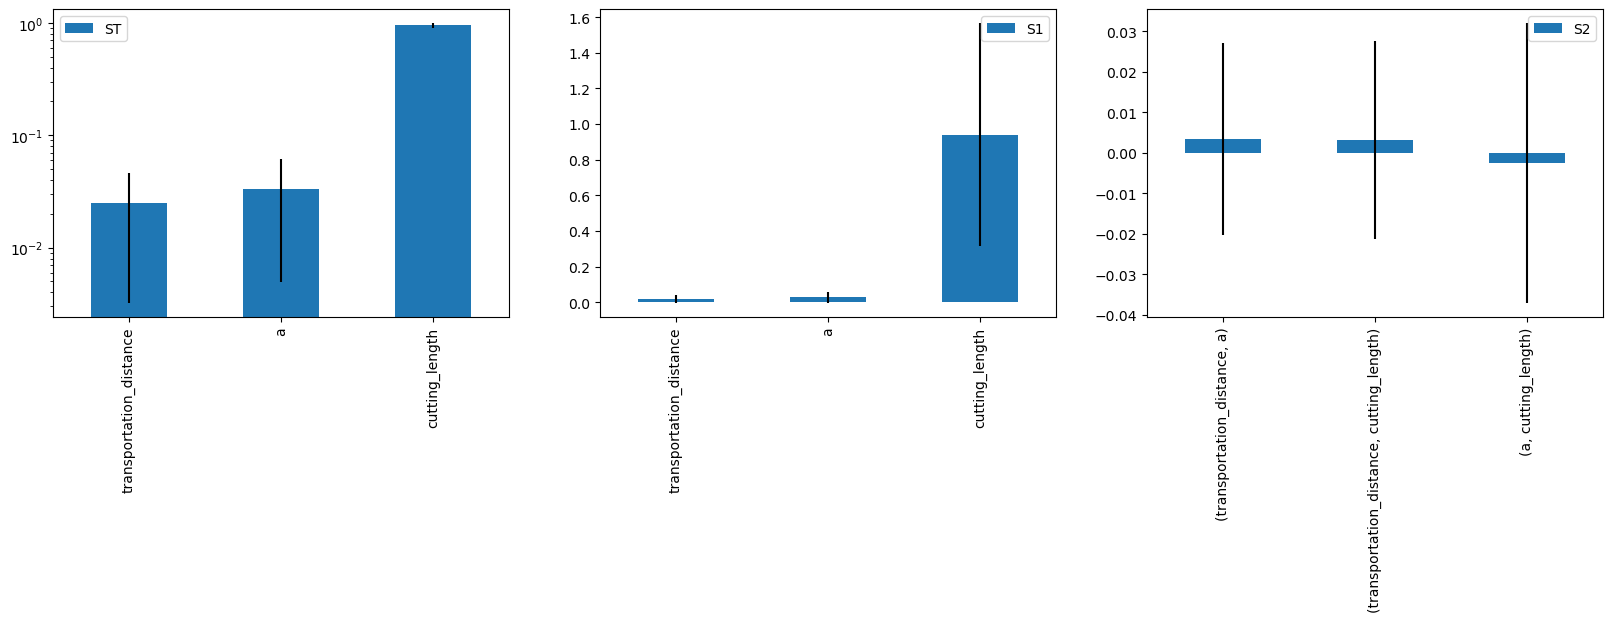

In [25]:
def calculate(transportation_distance, a, cutting_length):
# Calculate reuse impact and new impact for each cutting length
    # Calculate cutting time and other necessary parameters
    cutting_time = cutting_time_beam(cutting_depth,cutting_width, fast_cut_speed_area)
    max_num_concrete_beam = max_concrete_beam(cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete)
    total_weight_beam = total_weight_concrete_beam(cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete)
    
    # Calculate reuse impact and new impact
    reuse_impact =  transport_impact_lorry(total_weight_beam, a * transportation_distance)\
                    + cut_impact(cutting_time) * max_num_concrete_beam\
                    + reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam)
    new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length,cutting_depth, cutting_width, rho_light_reinforced_concrete) * max_num_concrete_beam\
                + transport_impact_truck(transportation_distance, total_weight_beam)

    return reuse_impact #new_impact

# Define the ranges for the input parameters
problem = {
    'num_vars': 3,
    'names': ['transportation_distance', 'a', 'cutting_length'],
    'bounds': [[50, 300], [0.5, 6], [0.01, 8]]
}

# Generate the samples using the Saltelli sampling method
param_values = saltelli.sample(problem, 1024)
# param_values = sobol.sample(problem, 1024)

# Run the model function and calculate the output for each sample
Y = np.zeros([param_values.shape[0]])
for i, X in enumerate(param_values):
    Y[i] = calculate(*X)
# select valid values not NAN
Y = Y[~np.isnan(Y)]
Y = Y[Y != 0]
# Perform the Sobol sensitivity analysis to calculate the sensitivity indices
Si = sobol_analyze.analyze(problem, Y) #, calc_second_order=True, print_to_console=False)

# Print the sensitivity indices
print('First order indices:', Si['S1'])
print('Total order indices:', Si['ST'])

import matplotlib.pyplot as plt
axes = Si.plot()
axes[0].set_yscale('log')
fig = plt.gcf()  # get current figure
fig.set_size_inches(20, 4)

# plt.tight_layout()
plt.show()

### **Sensitivity Analysis: Exploring the Influence of Transportation Distance and Ratio "a" on Minimum Cutting Length Outcomes**

C:\Users\xiong\AppData\Local\Temp\ipykernel_20060\249123812.py:37: DeprecationWarning:

`salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`

c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.

c:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning:

The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.



First order indices: [0.00798387 0.69324697]
Total order indices: [0.26745971 1.25639031]


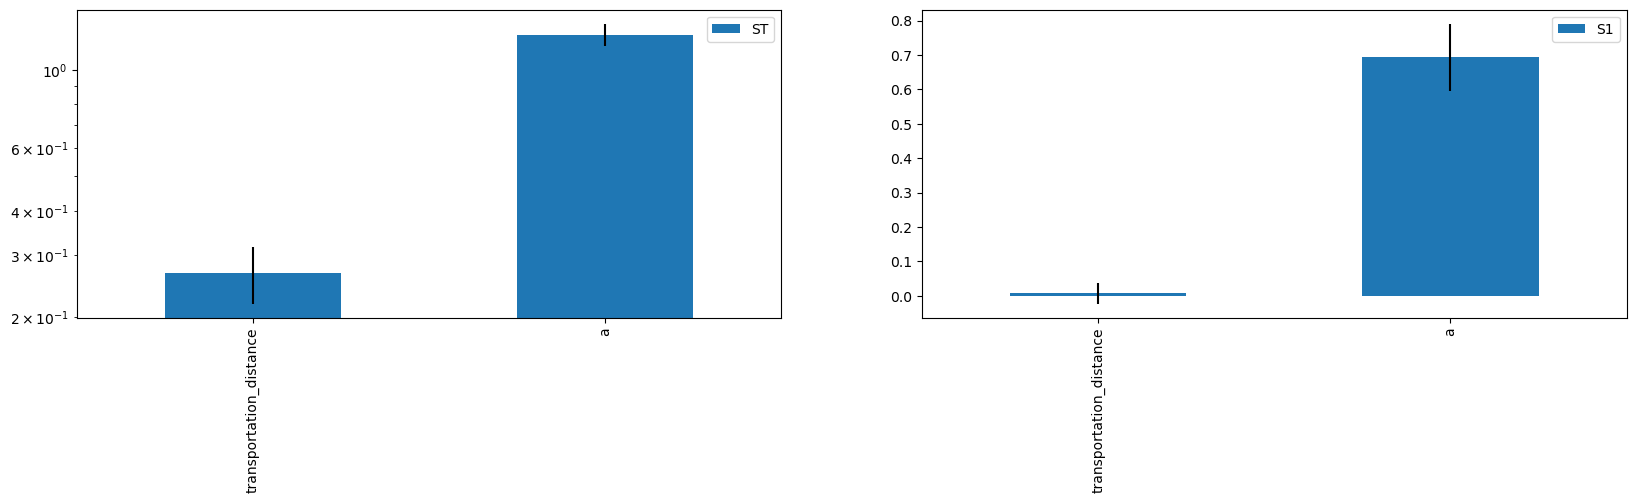

In [26]:

def calculate(transportation_distance, a):
# Calculate reuse impact and new impact for each cutting length
    # Define the range of cutting length
    cutting_length_range = np.linspace(0.01, 8, 100)  # Example range for cutting length
    # Initialize arrays to store the reuse impact and new impact values
    difference_values = []
    for cutting_length in cutting_length_range:
        # Calculate cutting time and other necessary parameters
        cutting_time = cutting_time_beam(cutting_depth,cutting_width, fast_cut_speed_area)
        max_num_concrete_beam = max_concrete_beam(cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete)
        total_weight_beam = total_weight_concrete_beam(cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete)
    
        # Calculate reuse impact and new impact
        reuse_impact = transport_impact_lorry(total_weight_beam, a * transportation_distance)\
                    + cut_impact_electricity(green_electricity_CO2_emission, cutting_time) * max_num_concrete_beam\
                    + reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam)
        new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete) * max_num_concrete_beam\
                    + transport_impact_truck(transportation_distance, total_weight_beam)
                    
        difference = reuse_impact - new_impact
        # Store the impact values
        difference_values.append(difference)
    # Find the intersection point with tolerance
    tolerance = 1e-5
    intersection_func = lambda x: np.interp(x, cutting_length_range, difference_values)
    intersection, = fsolve(intersection_func, cutting_length_range[0], xtol=tolerance)
    return intersection

# Define the ranges for the input parameters
problem = {
    'num_vars': 2,
    'names': ['transportation_distance', 'a'],
    'bounds': [[50, 300], [0.5, 6]]
}

# Generate the samples using the Saltelli sampling method
param_values = saltelli.sample(problem, 1024)
# param_values = sobol.sample(problem, 1024)

# Run the model function and calculate the output for each sample
Y = np.zeros([param_values.shape[0]])
for i, X in enumerate(param_values):
    Y[i] = calculate(*X)
# select valid values not NAN
Y = Y[~np.isnan(Y)]
Y = Y[Y != 0]
# Perform the Sobol sensitivity analysis to calculate the sensitivity indices
# Si = sobol_analyze.analyze(problem, Y) #, calc_second_order=True, print_to_console=False)
Si = sobol_analyze.analyze(problem, Y, calc_second_order=False)

# Print the sensitivity indices
print('First order indices:', Si['S1'])
print('Total order indices:', Si['ST'])

import matplotlib.pyplot as plt
axes = Si.plot()
axes[0].set_yscale('log')
fig = plt.gcf()  # get current figure
fig.set_size_inches(20, 4)

# plt.tight_layout()
plt.show()


## **Country Electricity Check**

In [3]:
import pandas as pd
import numpy as np
df_electricity_emission = pd.read_csv('country_electricity_emission.csv')
df_electricity_emission # kg CO2 per kWh

Country CODE  kg CO2-Eq
0             AE      1.063
1             AL      0.399
2             AM      0.231
3             AO      0.242
4             AR      0.389
..           ...        ...
163           XK      1.300
164           YE      0.910
165           ZA      1.100
166           ZM      0.170
167           ZW      0.670

[168 rows x 2 columns]

In [4]:
# calculate the carbon emission for cutting the concrete beam
def cut_impact(electricity_CO2_emission, cutting_time):
    impact_energy = (power * cutting_time) * (electricity_CO2_emission) # impact of electricity consumption 
    impact_blade = diamond_blade_CO2_emission * cutting_time
    impact_machine = cutting_time / span_machine * steel_CO2_emission * w_machine
    cut_impact = impact_energy + impact_blade + impact_machine
    return cut_impact

In [9]:
# loop through df_electricity_emission
df = df_electricity_emission
a = 1
transportation_distance = 100

for index, row in df.iterrows():
   
    # Define the range of size
    cutting_length_range = np.linspace(0.001, 6, 100)  # Example range for cutting length
    intersection_points = []
    electricity_CO2_emission= row['kg CO2-Eq'] # kgCO2eq/kWh from ecoinvent
    difference_values = []

    for cutting_length in cutting_length_range:
    

        # Calculate cutting time and other necessary parameters
        cutting_time = cutting_time_beam(cutting_depth,cutting_width,fast_cut_speed_area)
        max_num_concrete_beam = max_concrete_beam(cutting_length,cutting_depth, cutting_width,  rho_light_reinforced_concrete_beam)
        total_weight_beam = total_weight_concrete_beam(cutting_length,cutting_depth, cutting_width,  rho_light_reinforced_concrete_beam)
        
        # Calculate reuse impact and new impact
        reuse_impact = cut_impact(electricity_CO2_emission, cutting_time) * max_num_concrete_beam \
                    + transport_impact_lorry(total_weight_beam, a * transportation_distance) + reuse_glue_cost(total_weight_beam, glue_roundup_ratio, light_reinforced_concrete_emission_beam)
        new_impact = manufacturing_cost_beam(light_reinforced_concrete_emission_beam, cutting_length, cutting_depth, cutting_width, rho_light_reinforced_concrete_beam) * max_num_concrete_beam\
                    + transport_impact_truck(transportation_distance, total_weight_beam)
        difference = reuse_impact - new_impact
        # Store the impact values
        difference_values.append(difference)
 
    # Find the intersection point with tolerance
    tolerance = 1e-5
    intersection_func = lambda x: np.interp(x, cutting_length_range, difference_values)
    intersection, = fsolve(intersection_func, cutting_length_range[0], xtol=tolerance)
    intersection_points = intersection
    
    
    # print(intersection_point)
    df.loc[index,'cut_impact'] = reuse_impact
    df.loc[index,'minimum_size'] = intersection_points
                                                                
df

C:\Users\xiongs\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\xiongs\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Country CODE  kg CO2-Eq  cut_impact  minimum_size
0             AE      1.063  293.348444      0.236431
1             AL      0.399  282.951869      0.212111
2             AM      0.231  280.321410      0.204923
3             AO      0.242  280.493642      0.205408
4             AR      0.389  282.795294      0.211697
..           ...        ...         ...           ...
163           XK      1.300  297.059269      0.244094
164           YE      0.910  290.952847      0.231336
165           ZA      1.100  293.927771      0.237622
166           ZM      0.170  279.366303      0.202190
167           ZW      0.670  287.195049      0.222762

[168 rows x 4 columns]

In [11]:
import plotly.graph_objects as go

# Define energy intensity categories
low_energy = df['kg CO2-Eq'].quantile(0.33)
high_energy = df['kg CO2-Eq'].quantile(0.67)

# Create box plot
fig = go.Figure()

# Add low energy intensity box
low_energy_df = df[df['kg CO2-Eq'] <= low_energy]
fig.add_trace(go.Box(
    y=low_energy_df['minimum_size'],
    name='Low Energy Intensity'
))

# Add medium energy intensity box
medium_energy_df = df[(df['kg CO2-Eq'] > low_energy) & (df['kg CO2-Eq'] <= high_energy)]
fig.add_trace(go.Box(
    y=medium_energy_df['minimum_size'],
    name='Medium Energy Intensity'
))

# Add high energy intensity box
high_energy_df = df[df['kg CO2-Eq'] > high_energy]
fig.add_trace(go.Box(
    y=high_energy_df['minimum_size'],
    name='High Energy Intensity'
))

# Set layout
fig.update_layout(
    title='Min. Cut Length vs. Energy Intensity',
    xaxis=dict(title='Energy Intensity'),
    yaxis=dict(title='Min. Cut Length'), # modify y-axis range
    width=800,
    height=600,
)
fig.update_layout(template="simple_white")

# Show figure
fig.show()
